In [1]:
# !pip install hyperopt --user

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF


from xgboost import plot_importance as plot_importance_xgb
from lightgbm import plot_importance as plot_importance_lgbm

# Import necessary libraries
from hyperopt import fmin, tpe, hp
from hyperopt import Trials
from hyperopt import space_eval
from sklearn.model_selection import cross_val_score

In [3]:
pd.set_option("max_column", None)

In [55]:
# Load the dataset
df = pd.read_csv('airlines_delay.csv').sample(16000, random_state=42).reset_index().drop("index", axis=1)

In [56]:
# Display first few rows of the dataset
df.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,728.0,610.0,375.0,WN,PVD,LAS,7,0
1,716.0,685.0,243.0,B6,SJU,JFK,2,1
2,1103.0,590.0,65.0,AA,ORD,STL,5,0
3,853.0,610.0,105.0,WN,LAS,SFO,2,1
4,6992.0,483.0,43.0,OO,LAX,CLD,2,0


In [11]:
# Get general statistics of the dataset

df.describe()

,Flight,Time,Length,DayOfWeek,Class
count,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000
mean,2420.603625,800.952312,132.847813,3.935375,0.451062
std,2066.768792,277.962982,71.954532,1.906450,0.497615
min,1.000000,15.000000,0.000000,1.000000,0.000000
25%,709.000000,561.000000,81.000000,2.000000,0.000000
50%,1792.000000,794.000000,115.000000,4.000000,0.000000
75%,3737.250000,1031.000000,163.000000,5.000000,1.000000
max,7812.000000,1439.000000,655.000000,7.000000,1.000000


In [12]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Flight         0
Time           0
Length         0
Airline        0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Class          0
dtype: int64


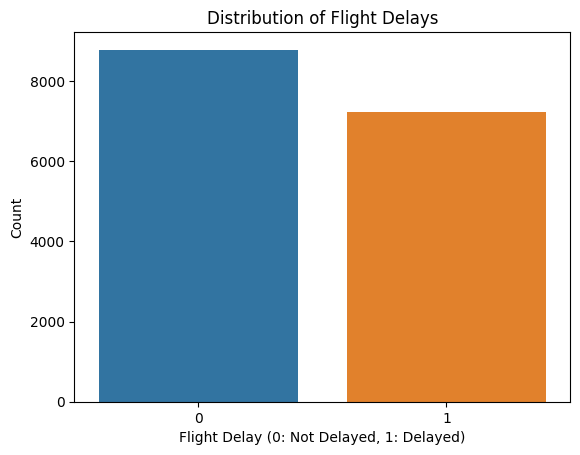

In [13]:
# Explore distribution of Class (target variable)
sns.countplot(x='Class', data=df)
plt.xlabel('Flight Delay (0: Not Delayed, 1: Delayed)')
plt.ylabel('Count')
plt.title('Distribution of Flight Delays')
plt.show()

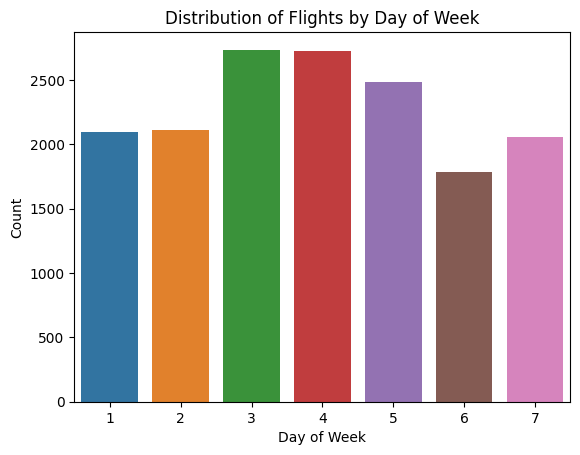

In [14]:
# Explore distribution of DayOfWeek
sns.countplot(x='DayOfWeek', data=df)
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.title('Distribution of Flights by Day of Week')
plt.show()

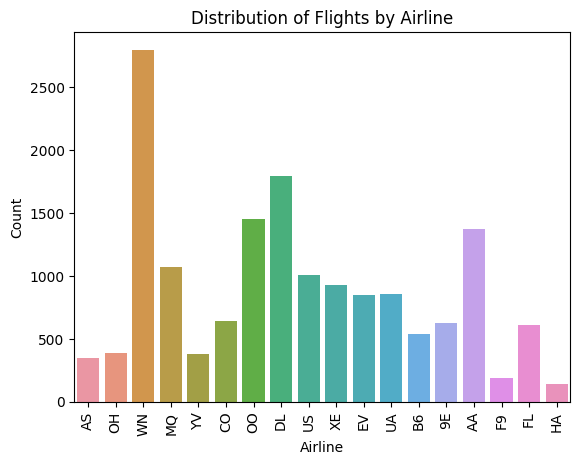

In [15]:
# Explore distribution of Airline
sns.countplot(x='Airline', data=df)
plt.xlabel('Airline')
plt.ylabel('Count')
plt.title('Distribution of Flights by Airline')
plt.xticks(rotation=90)
plt.show()

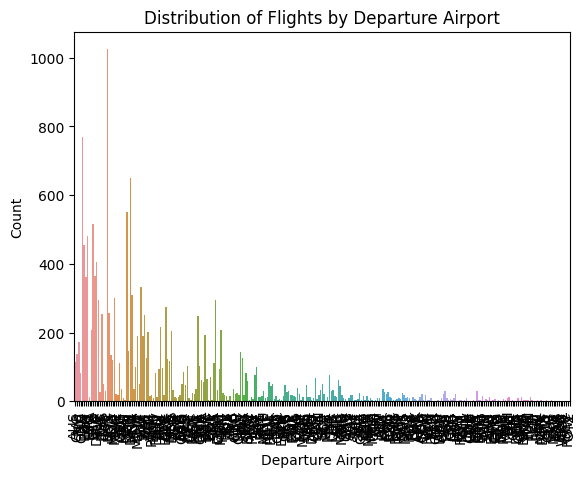

In [16]:
# Explore distribution of AirportFrom
sns.countplot(x='AirportFrom', data=df)
plt.xlabel('Departure Airport')
plt.ylabel('Count')
plt.title('Distribution of Flights by Departure Airport')
plt.xticks(rotation=90)
plt.show()

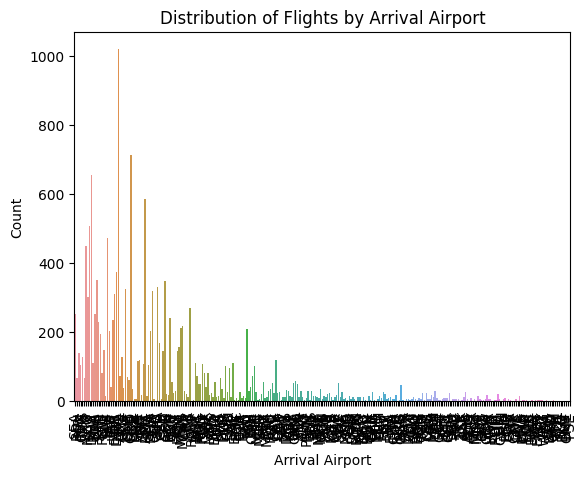

In [17]:
# Explore distribution of AirportTo
sns.countplot(x='AirportTo', data=df)
plt.xlabel('Arrival Airport')
plt.ylabel('Count')
plt.title('Distribution of Flights by Arrival Airport')
plt.xticks(rotation=90)
plt.show()

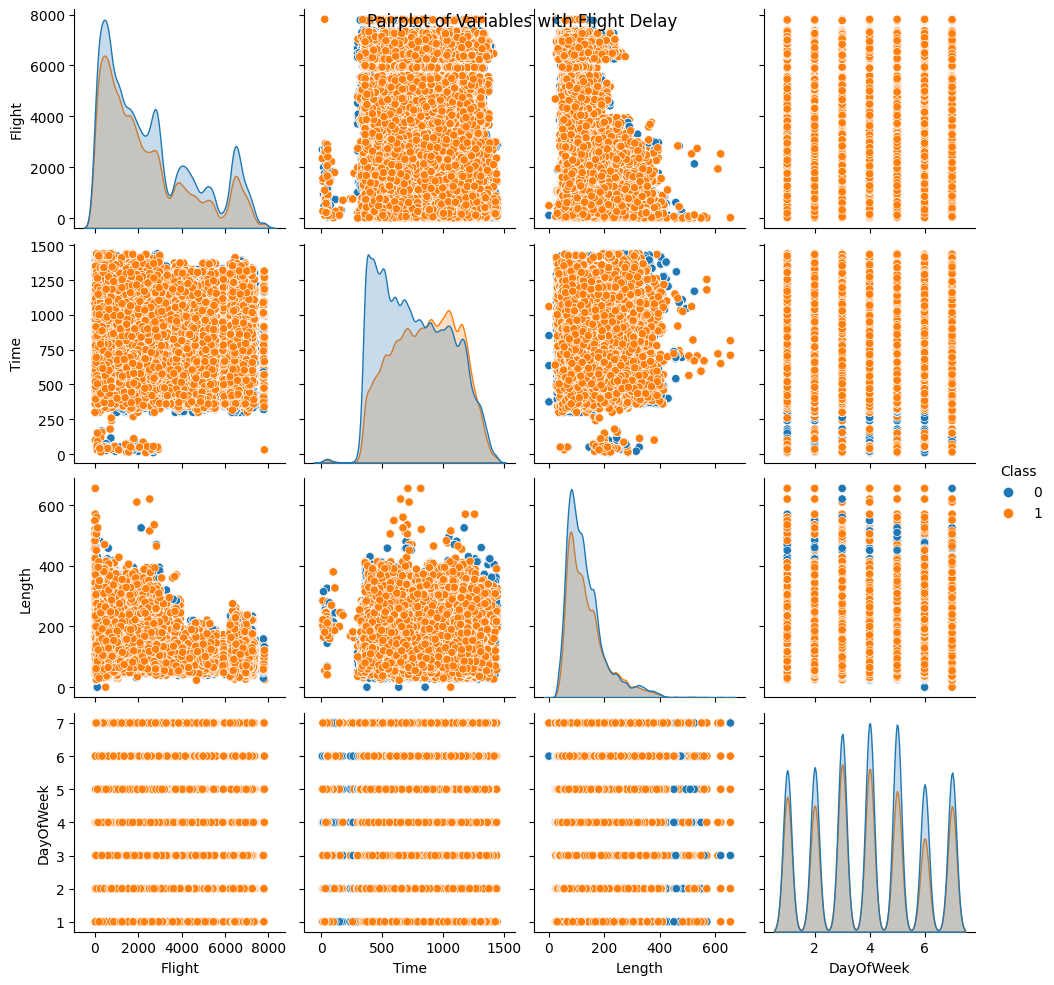

In [12]:
# Explore interactions between variables
sns.pairplot(df, hue='Class', diag_kind='kde')
plt.suptitle('Pairplot of Variables with Flight Delay')
plt.show()

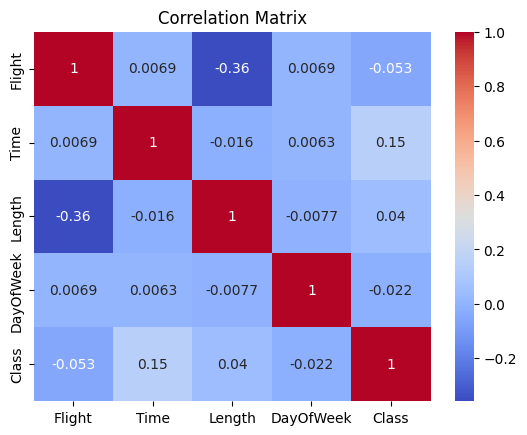

In [18]:
# Calculate correlation matrix
corr = df.corr()

# Plot correlation matrix
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [19]:
df.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
524400,669.0,1095.0,254.0,AS,AUS,SEA,4,1
63403,6389.0,1140.0,118.0,OH,CVG,BDL,6,0
261279,2312.0,595.0,205.0,WN,FLL,MCI,6,1
382046,7.0,1295.0,105.0,WN,SJC,PDX,7,0
281446,4368.0,880.0,70.0,MQ,ORD,CVG,6,0


In [20]:
# Create aggregated features
# Aggregating data to the level of the airline
airline_agg = df.groupby('Airline').agg({
    'Length': ['mean', 'min', 'max'],
    'DayOfWeek': 'count',
   # 'Class': 'mean'
}).reset_index()
# Rename columns
airline_agg.columns = ['Airline', 'AirlineAvgLength', 'AirlineMinLength', 'AirlineMaxLength', 'AirlineNumFlights']
airline_agg

,Airline,AirlineAvgLength,AirlineMinLength,AirlineMaxLength,AirlineNumFlights
0,9E,96.782194,42.0,177.0,629
1,AA,173.367733,55.0,560.0,1376
2,AS,171.709770,39.0,413.0,348
3,B6,175.653558,63.0,405.0,534
4,CO,196.286604,47.0,655.0,642
5,DL,158.492762,49.0,610.0,1796
6,EV,92.058754,40.0,221.0,851
7,F9,154.569892,0.0,270.0,186
8,FL,135.536066,57.0,345.0,610
9,HA,108.078014,30.0,405.0,141


In [21]:
# Aggregating data to the level of the airport
airport_agg = df.groupby('AirportFrom').agg({
    'Length': ['mean', 'min', 'max'],
    'DayOfWeek': 'count',
    #'Class': 'mean'
}).reset_index()

# Rename columns
airport_agg.columns = ['AirportFrom', 'AirportFromAvgLength', 'AirportFromMinLength', 'AirportFromMaxLength', 'AirportFromNumFlights']
airport_agg

,AirportFrom,AirportFromAvgLength,AirportFromMinLength,AirportFromMaxLength,AirportFromNumFlights
0,ABE,133.625000,106.0,163.0,8
1,ABI,50.000000,50.0,50.0,11
2,ABQ,109.953488,60.0,216.0,86
3,ABY,61.000000,61.0,61.0,1
4,ACV,66.500000,27.0,82.0,12
...,...,...,...,...,...
274,VPS,100.588235,73.0,135.0,17
275,WRG,39.000000,39.0,39.0,1
276,XNA,108.000000,66.0,180.0,36
277,YAK,48.000000,46.0,52.0,3


In [22]:
# Aggregating data to the level of the route
df['Route'] = df['AirportFrom'] + '-' + df['AirportTo']
route_agg = df.groupby('Route').agg({
    'Length': ['mean', 'min', 'max'],
    'DayOfWeek': 'count',
    #'Class': 'mean'
}).reset_index()
# Rename columns
route_agg.columns = ['Route', 'RouteAvgLength', 'RouteMinLength', 'RouteMaxLength', 'RouteNumFlights']
route_agg

,Route,RouteAvgLength,RouteMinLength,RouteMaxLength,RouteNumFlights
0,ABE-ATL,154.000000,145.0,163.0,2
1,ABE-CLT,106.000000,106.0,106.0,1
2,ABE-DTW,111.500000,110.0,113.0,2
3,ABE-MCO,156.000000,156.0,156.0,1
4,ABE-ORD,138.000000,136.0,140.0,2
...,...,...,...,...,...
3541,XNA-ORD,105.090909,105.0,106.0,11
3542,YAK-CDV,52.000000,52.0,52.0,1
3543,YAK-JNU,46.000000,46.0,46.0,2
3544,YUM-LAX,80.000000,80.0,80.0,6


In [23]:
# Merge the aggregated features back to the original dataset
df = pd.merge(df, airline_agg, on='Airline', how='left')
df = pd.merge(df, airport_agg, on='AirportFrom', how='left')
df = pd.merge(df, route_agg, on='Route', how='left')

In [24]:
df.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class,Route,AirlineAvgLength,AirlineMinLength,AirlineMaxLength,AirlineNumFlights,AirportFromAvgLength,AirportFromMinLength,AirportFromMaxLength,AirportFromNumFlights,RouteAvgLength,RouteMinLength,RouteMaxLength,RouteNumFlights
0,669.0,1095.0,254.0,AS,AUS,SEA,4,1,AUS-SEA,171.709770,39.0,413.0,348,123.617391,45.0,254.0,115,254.000000,254.0,254.0,1
1,6389.0,1140.0,118.0,OH,CVG,BDL,6,0,CVG-BDL,109.927649,48.0,252.0,387,123.391304,45.0,317.0,138,118.400000,118.0,119.0,5
2,2312.0,595.0,205.0,WN,FLL,MCI,6,1,FLL-MCI,117.250000,45.0,380.0,2800,161.693642,60.0,380.0,173,207.500000,205.0,210.0,2
3,7.0,1295.0,105.0,WN,SJC,PDX,7,0,SJC-PDX,117.250000,45.0,380.0,2800,107.320988,55.0,319.0,81,108.333333,105.0,110.0,3
4,4368.0,880.0,70.0,MQ,ORD,CVG,6,0,ORD-CVG,101.575163,40.0,220.0,1071,128.804688,38.0,560.0,768,72.454545,68.0,86.0,11


In [25]:
# Select columns with data type 'object'
object_cols = df.select_dtypes(include='object').columns.tolist()
print(object_cols)

from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

for i in object_cols:
    # Apply label encoding to a specific column in the dataframe
    df[i] = label_encoder.fit_transform(df[i])

['Airline', 'AirportFrom', 'AirportTo', 'Route']


In [26]:
#df = df.astype(np.float32)

In [27]:
# Extract features and target variable
X = df.drop('Class', axis=1)
y = df['Class']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [28]:
X_train.shape, y_train.shape, X_test.shape

((9600, 20), (9600,), (6400, 20))

In [29]:
# Train and evaluate XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [30]:
xgb_pred = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred)
print('XGBoost Accuracy:', xgb_acc)

XGBoost Accuracy: 0.61203125


In [31]:
# Train and evaluate CatBoost model
catboost_model = CatBoostClassifier()
catboost_model.fit(X_train, y_train, verbose=False)

In [32]:
catboost_pred = catboost_model.predict(X_test)
catboost_acc = accuracy_score(y_test, catboost_pred)
print('CatBoost Accuracy:', catboost_acc)

CatBoost Accuracy: 0.6365625


In [33]:
# Train and evaluate LightGBM model
lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train, y_train)

LGBMClassifier()

In [34]:
lgbm_pred = lgbm_model.predict(X_test)
lgbm_acc = accuracy_score(y_test, lgbm_pred)
print('LightGBM Accuracy:', lgbm_acc)

LightGBM Accuracy: 0.631875


In [35]:
# Identify important features
xgb_importance = xgb_model.feature_importances_
catboost_importance = catboost_model.feature_importances_
lgbm_importance = lgbm_model.feature_importances_

In [36]:
# Print feature importances
print('XGBoost Feature Importances:', xgb_importance)
print('CatBoost Feature Importances:', catboost_importance)
print('LightGBM Feature Importances:', lgbm_importance)


XGBoost Feature Importances: [0.03385853 0.04977267 0.03079129 0.06072735 0.03214109 0.03951954
 0.03154822 0.03610686 0.05605046 0.05305861 0.04329701 0.21660356
 0.03599517 0.03624514 0.03487628 0.04671694 0.04313436 0.04515327
 0.04317819 0.03122554]
CatBoost Feature Importances: [ 7.49085672 16.3014915   4.51376206  3.24474432  2.77084517  7.70065424
  7.55903563  3.52338446  1.70142711  3.48598258  1.88755775 10.55607334
  4.44941705  4.40023803  2.88483089  3.53528503  2.85805681  3.24314271
  3.3972803   4.49593431]
LightGBM Feature Importances: [320 443 183  79 126 249 167 128  53  69  23  84 150 131 127 156 104 125
 130 153]


In [38]:
# Define a function to plot confusion matrix for train and test
def plot_confusion_matrix(X_train, y_train, X_test, y_test, model):
    # Extract model name from model instance
    model_name = type(model).__name__
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate confusion matrices for train and test
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)
    
    labels = sorted(set(y_train + y_pred_train))
    
    # Create subplots for train and test confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Plot train confusion matrix
    sns.heatmap(cm_train, 
                annot=True, 
                cmap="Blues", 
                fmt="d", 
                cbar=False, 
#                 xticklabels=labels, 
#                 yticklabels=labels, 
                ax=axes[0])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    axes[0].set_title(f'Train: {model_name}')
    
    # Plot test confusion matrix
    sns.heatmap(cm_test, 
                annot=True, 
                cmap="Blues", 
                fmt="d", 
                cbar=False, 
#                 xticklabels=labels, 
#                 yticklabels=labels, 
                ax=axes[1])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_title(f'Test: {model_name}')
    
    #plt.tight_layout()
    plt.show()

In [37]:
# Define the Gaussian Process kernel (Radial Basis Function kernel)
kernel = 1.0 * RBF()

# Create Gaussian Process Classifier
gp_classifier = GaussianProcessClassifier(kernel=kernel, random_state=42)

# Fit the classifier on the training data
gp_classifier.fit(X_train, y_train)


Accuracy: 62.52%


In [41]:
# Make predictions on the test data
gp_pred = gp_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, gp_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 62.52%


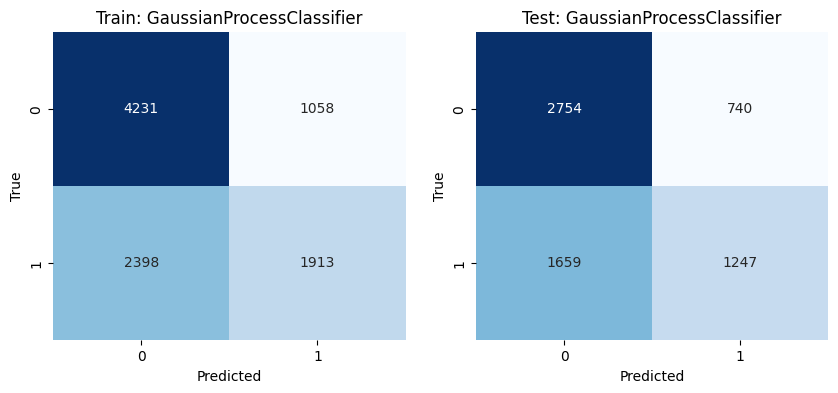

In [39]:
# Plot train and test confusion matrix for XGBoost
plot_confusion_matrix(X_train, y_train, X_test, y_test, gp_classifier)

In [40]:
# Evaluate model performance
def evaluate_model_performance(y_true, y_preds, model, split):
    model_name = type(model).__name__
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    
    return pd.Series({'Model': model_name,
                      'Train/Test': split,
                      'Accuracy': accuracy,
                      'Precision': precision,
                      'Recall': recall,
                      'F1 Score': f1})

In [42]:
# Create a DataFrame to store the evaluation metrics
results_df = pd.DataFrame(columns=['Model', 'Train/Test', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
results_df = results_df.append(evaluate_model_performance(y_train, xgb_model.predict(X_train), xgb_model, 'Train'), ignore_index=True)
results_df = results_df.append(evaluate_model_performance(y_test, xgb_pred, xgb_model, 'Test'), ignore_index=True)

results_df = results_df.append(evaluate_model_performance(y_train, catboost_model.predict(X_train), catboost_model, 'Train'), ignore_index=True)
results_df = results_df.append(evaluate_model_performance(y_test, catboost_pred, catboost_model, 'Test'), ignore_index=True)

results_df = results_df.append(evaluate_model_performance(y_train, lgbm_model.predict(X_train), lgbm_model, 'Train'), ignore_index=True)
results_df = results_df.append(evaluate_model_performance(y_test, lgbm_pred, lgbm_model, 'Test'), ignore_index=True)

results_df = results_df.append(evaluate_model_performance(y_train, gp_classifier.predict(X_train), gp_classifier, 'Train'), ignore_index=True)
results_df = results_df.append(evaluate_model_performance(y_test, gp_pred, gp_classifier, 'Test'), ignore_index=True)

In [43]:
results_df.T

,0,1,2,3,4,5,6,7
Model,XGBClassifier,XGBClassifier,CatBoostClassifier,CatBoostClassifier,LGBMClassifier,LGBMClassifier,GaussianProcessClassifier,GaussianProcessClassifier
Train/Test,Train,Test,Train,Test,Train,Test,Train,Test
Accuracy,0.884167,0.612031,0.789062,0.636563,0.795208,0.631875,0.64,0.625156
Precision,0.893869,0.580941,0.811275,0.622054,0.817837,0.616624,0.643891,0.627579
Recall,0.842032,0.522368,0.691023,0.508603,0.699838,0.500344,0.443749,0.429112
F1 Score,0.867176,0.5501,0.746336,0.559637,0.75425,0.552432,0.525405,0.509708


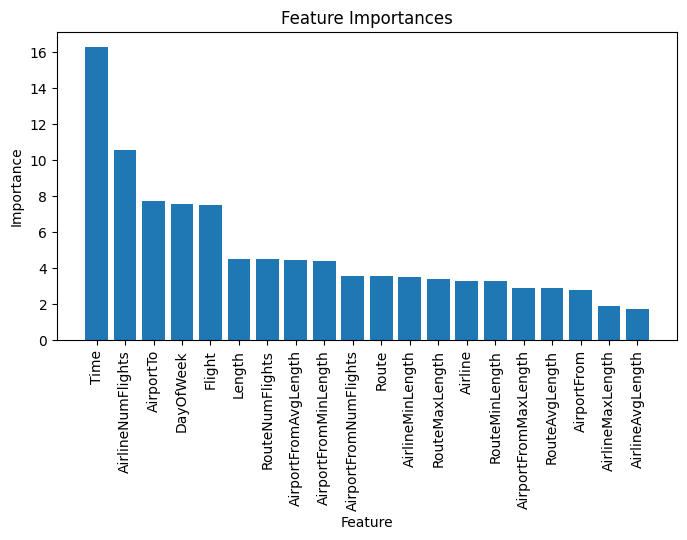

In [44]:
# Get feature importances
feature_importances = catboost_model.get_feature_importance()
feature_names = X_train.columns

# Sort feature importances in descending order
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(8, 4))
plt.bar(range(len(feature_names)), feature_importances[sorted_idx])
plt.xticks(range(len(feature_names)), feature_names[sorted_idx], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

In [45]:
feat = dict(zip(feature_names, feature_importances))
feat

{'Flight': 7.4908567176166905,
 'Time': 16.30149149520113,
 'Length': 4.513762063267487,
 'Airline': 3.244744322111556,
 'AirportFrom': 2.770845167307833,
 'AirportTo': 7.700654243953857,
 'DayOfWeek': 7.559035632871287,
 'Route': 3.5233844586841148,
 'AirlineAvgLength': 1.7014271057102406,
 'AirlineMinLength': 3.4859825818678467,
 'AirlineMaxLength': 1.8875577503462577,
 'AirlineNumFlights': 10.55607334286417,
 'AirportFromAvgLength': 4.449417052701764,
 'AirportFromMinLength': 4.400238027700153,
 'AirportFromMaxLength': 2.884830892517283,
 'AirportFromNumFlights': 3.5352850267673994,
 'RouteAvgLength': 2.8580568055128364,
 'RouteMinLength': 3.243142708531938,
 'RouteMaxLength': 3.3972802984517454,
 'RouteNumFlights': 4.495934306014406}

<Figure size 1200x800 with 0 Axes>

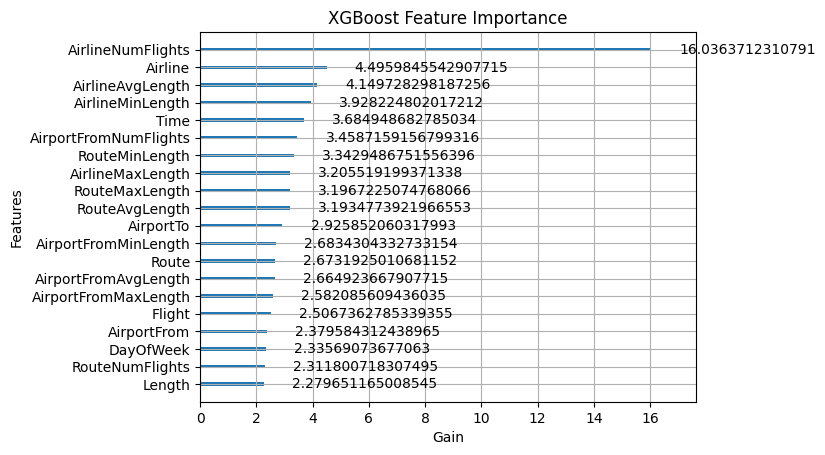

In [46]:
# Plot XGBoost feature importance
plt.figure(figsize=(12, 8))
plot_importance_xgb(xgb_model, importance_type='gain', title='XGBoost Feature Importance', xlabel='Gain')
plt.show()

<Figure size 1200x800 with 0 Axes>

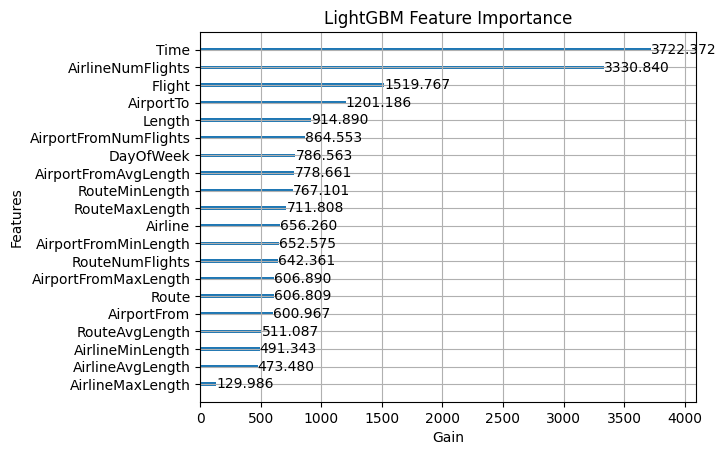

In [47]:
# Plot LightGBM feature importance
plt.figure(figsize=(12, 8))
plot_importance_lgbm(lgbm_model, importance_type='gain', title='LightGBM Feature Importance', xlabel='Gain')
plt.show()

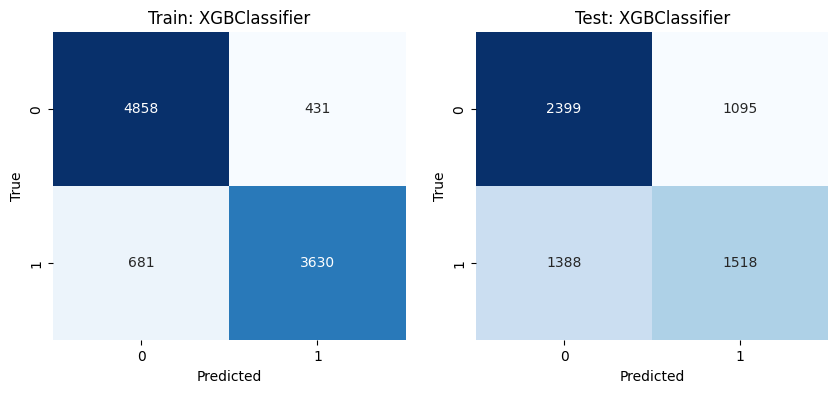

In [48]:
# Plot train and test confusion matrix for XGBoost
plot_confusion_matrix(X_train, y_train, X_test, y_test, xgb_model)

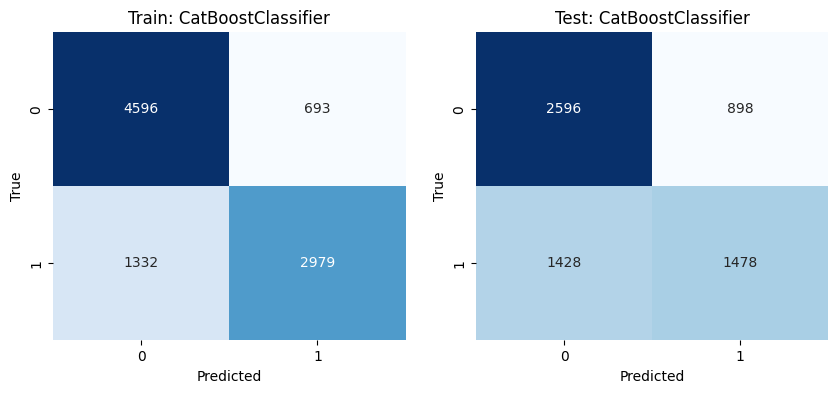

In [49]:
# Plot train and test confusion matrix for XGBoost
plot_confusion_matrix(X_train, y_train, X_test, y_test, catboost_model)

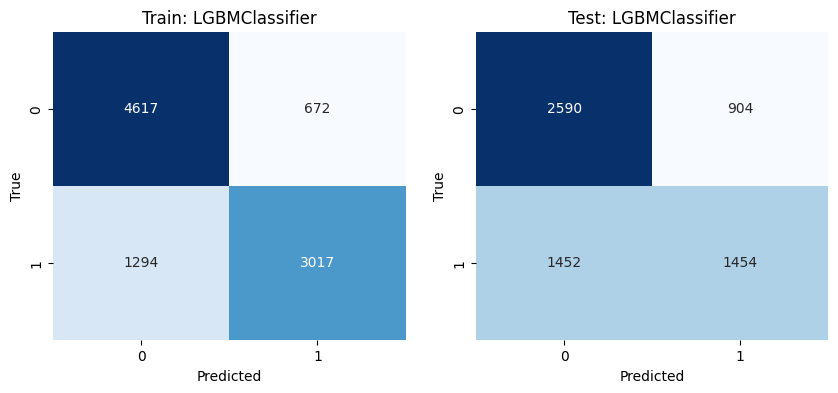

In [50]:
# Plot train and test confusion matrix for XGBoost
plot_confusion_matrix(X_train, y_train, X_test, y_test, lgbm_model)